In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression

In [5]:
natgas_df=pd.read_csv('//content/drive/MyDrive/JP Morgan Quantitative research/Nat_Gas.csv')

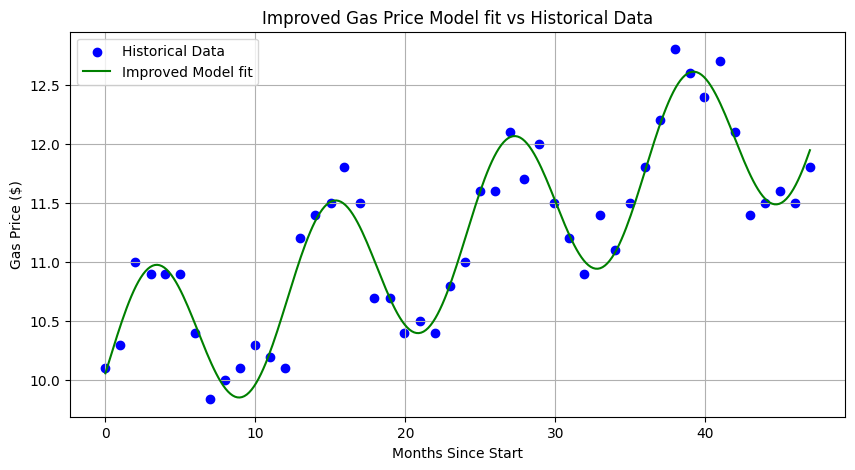

In [8]:
from scipy.optimize import curve_fit

natgas_df['Dates'] = pd.to_datetime(natgas_df['Dates'])
# Calculate the time difference in days and convert to months
natgas_df['Months_Since_Start'] = (natgas_df['Dates'] - natgas_df['Dates'].min()).dt.days / 30.44

def linear_sin_model(x, a, b, c, d,e, f):
    """
    Combination of Linear and Sin function,

    Parameters:
        x: Input date array (in months since the start of the data)
        a,b,c: Coefficients for the linear component: a*x+b+c
        d,e,f: Coefficients for the sin component: d*sin(2*pi*(e*x+f))

    Returns:
        Predicted gas prices based on the input date array.
    """
    return a*x+b+c+d*np.sin(2*np.pi*(e*x+f))

# Fitting the model
x_data = natgas_df['Months_Since_Start']
y_data = natgas_df['Prices']
params, params_covariance = curve_fit(linear_sin_model, x_data, y_data, p0=[0.01, 10, 0, 1, 0.1, 0])

params

# Predict using the fitted model across the data range
x_model = np.linspace(x_data.min(), x_data.max(), 300)
y_model = linear_sin_model(x_model, *params)

# Plotting the new fit
plt.figure(figsize=(10, 5))
plt.scatter(x_data, y_data, color='blue',label='Historical Data')
plt.plot(x_model, y_model,  color='green', linestyle='-', label='Improved Model fit')
plt.title('Improved Gas Price Model fit vs Historical Data')
plt.xlabel('Months Since Start')
plt.ylabel('Gas Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
def predict_gas_price(date):
    """
    Predict the gas price for a given date using historical data or the model.

    Parameters:
        date (str): Date in the format 'YYYY-MM-DD'.Assumes the date is the end of the month.

    Returns:
        float: The predicted or historical gas price.
    """
    # Convert the input string to a datetime
    input_date = pd.to_datetime(date)

    # Check if the date exists in the historical data
    if input_date in natgas_df['Dates'].values:
        # Return the corresponding historical price
        return natgas_df.loc[natgas_df['Dates'] == input_date, 'Prices'].values[0]
    else:
         # Calculate the number of months since the start of the data
         months_since_start = (input_date - natgas_df['Dates'].min()).days / 30.44

         # Predict using the model
         predicted_price = linear_sin_model(months_since_start, *params)
         return predicted_price

# Test the function with a date from the historical data and a future date
test_date_historical = "31/12/2022" # Historical data
test_date_future  = "30/4/2025"     # Future data

predict_gas_price(test_date_historical), predict_gas_price(test_date_future)

<ipython-input-9-3672684979>:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  input_date = pd.to_datetime(date)


(np.float64(11.6), np.float64(12.577544251746842))

In [16]:
# Calculate the value of the gas storage contract using the predicted gas prices
def calculate_contract_value_model(injection_dates, withdrawal_dates, injection_rate, injection_withdrawal_costs,max_storage_volume, storage_cost_per_month):
    total_profit = 0
    avg_num_months = 30.42

    for i in range(len(injection_dates)):
        injection_price = predict_gas_price(injection_dates[i])
        print('injection_price:', injection_price)
        withdrawal_price = predict_gas_price(withdrawal_dates[i])
        print('withdrawal_price:', withdrawal_price)

        months_in_store = (pd.to_datetime(withdrawal_dates[i]) - pd.to_datetime(injection_dates[i])).days / 30.44
        print('months_in_store:', months_in_store)
        total_injected_volume = min(months_in_store * injection_rate, max_storage_volume)
        print('total_injected_volume:', total_injected_volume)

        cost_of_injection = (total_injected_volume * injection_price) - (total_injected_volume/1000000 * injection_withdrawal_costs)
        print('cost_of_injection:', cost_of_injection)
        revenue_from_sale = total_injected_volume * (withdrawal_price)
        print('revenue_from_sale:', revenue_from_sale)
        total_storage_cost = months_in_store * storage_cost_per_month
        print('total_storage_cost:', total_storage_cost)

        total_profit += (revenue_from_sale - cost_of_injection - total_storage_cost)

    return total_profit

# Sample parameters for testing
injection_dates = ['31/10/2024']
withdrawal_dates = ['28/2/2025']
injection_rate = 1000000 # MMBtu per month
injection_withdrawal_costs = 10000 # per MMBtu
max_storage_volume = 50000000 # MMBtu
storage_cost_per_month = 100000 # per MMBtu

# Calculate the contract value using the model
calculate_contract_value_model(injection_dates, withdrawal_dates, injection_rate, injection_withdrawal_costs,max_storage_volume, storage_cost_per_month)

injection_price: 12.349197536258899
withdrawal_price: 13.096962456950259
months_in_store: 3.9421813403416555
total_injected_volume: 3942181.3403416555
cost_of_injection: 48643354.28222956
revenue_from_sale: 51630601.01294451
total_storage_cost: 394218.13403416553


<ipython-input-9-3672684979>:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  input_date = pd.to_datetime(date)


np.float64(2593028.596680789)